In [ ]:
# run those lines if you haven't installed gym yet.
# !pip install --upgrade gym >> install.log

# the lines below is only needed if you run on an everware server
# !apt-get -qq update 
# !apt-get install -y xvfb >> install.log
# !apt-get install -y ffmpeg >> install.log

In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ./xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb./xvfb: line 8: start-stop-daemon: command not found
.
env: DISPLAY=:1


# Practice: "deep" crossentropy method with neural nets
This notebook will teach you to solve reinforcement learning problems with crossentropy method with neural network policy.

![img](https://casd35.wikispaces.com/file/view/digging_deeper_final.jpg/359658499/503x260/digging_deeper_final.jpg)

In this section we will train a neural network policy for continuous state space game

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

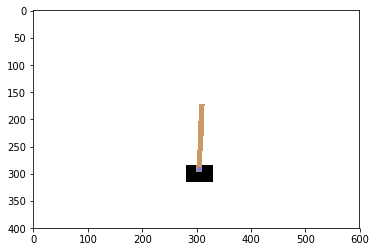

In [42]:
import gym

env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

In [6]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions, range(n_actions));

/Users/maxim/miniconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [39]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Activation, Flatten, MaxPooling2D, BatchNormalization
from keras import optimizers
from keras.layers.core import Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras import regularizers
from keras.callbacks import EarlyStopping, TensorBoard

/Users/maxim/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/maxim/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [156]:
class Agent:
    def __init__(self, model=None):
        self.num_classes = None
        self.model = model

    def build_model(self, input_dim=4, num_classes=n_actions, l2_reg=1e-7, lr=0.001, lr_decay=2e-6):
        self.num_classes = num_classes
        model = Sequential()
        
        model.add(Dense(128, kernel_regularizer=regularizers.l2(l2_reg), input_dim=input_dim))
        model.add(LeakyReLU())
        model.add(BatchNormalization())

        model.add(Dropout(0.3))
        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))
        
        #optimization details
        adam = optimizers.Adam(lr=lr, decay=lr_decay)
        model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
        
        self.model = model
        
    def predict(self, X, verbose=0):
        return self.model.predict(X, verbose=verbose)
    
    
    def predict_proba(self, X, verbose=0):
        return self.model.predict_proba(X, verbose=verbose)
    
    
    def fit(self, X, y, verbose=0):
        return self.model.fit(X, y, verbose=verbose)
        
    
    def get_test_score(self, X, y):
        # Score trained model.
        scores = self.model.evaluate(X, y, verbose=1)
        print('Test loss:', scores[0])
        print('Test accuracy:', scores[1])

In [157]:
agent = Agent()
agent.build_model(input_dim=4)

### Generating sessions

In the next section we can use agent's predict_proba method to sample actions.

In [164]:
def generate_session(t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba(s.reshape((-1,4)))[0]
        
        a = np.random.choice(n_actions,p=probs)
        
        new_s,r,done,info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done: break
    return states,actions,total_reward
        

In [165]:
s,a,r = generate_session()
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float]

In [166]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(10)]
env.close()

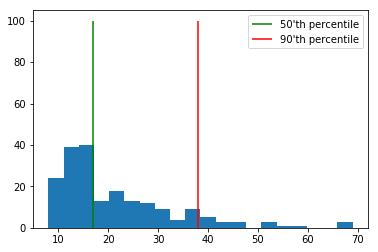

In [167]:
#let's see the initial reward distribution
sample_rewards = [generate_session()[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()

### Crossentropy method steps (2pts)

In [168]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    reward_threshold = np.percentile(rewards_batch,percentile)
    
    elite_states = [s for states, r in zip(states_batch, rewards_batch) if r >= reward_threshold for s in states]
    elite_actions = [a for actions, r in zip(actions_batch, rewards_batch) if r >= reward_threshold for a in actions]
    
    return elite_states,elite_actions
    

In [169]:
states_batch = [
    [1,2,3],   #game1
    [4,2,0,2], #game2
    [3,1]      #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = [
    3,         #game1
    4,         #game2
    5,         #game3
]

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


# Training loop
Generate sessions, select N best and fit to those.

In [170]:
from IPython.display import clear_output

def show_progress(rewards_batch,log, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


## Main loop

We can now combine the functions we wrote to train the agent with crossentropy method.

In [180]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
onehot_encoder.fit([[0], [1]])

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

mean reward = 192.370, threshold=200.000


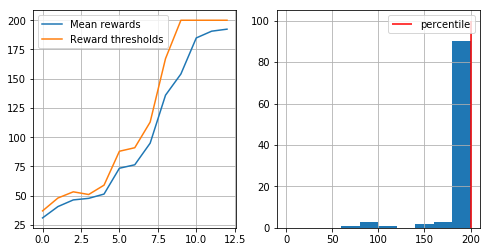

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [186]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    #generate new sessions
    sessions = [generate_session() for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = map(np.array,zip(*sessions))

    elite_states, elite_actions = map(np.array, select_elites(states_batch,actions_batch,rewards_batch,percentile))
    
    agent.fit(elite_states.reshape((-1, 4)), onehot_encoder.transform(elite_actions.reshape((-1,1))).toarray())

    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    if np.mean(rewards_batch)> 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [188]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [32]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Hometask

Replace MLPClassifier with torch NN